In [1]:
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx
import networkx as nx

In [7]:
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    TORCH = torch.__version__.split("+")[0]
    CUDA = "cu" + torch.version.cuda.replace(".","")
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
import torch_geometric #download torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch_geometric-2.2.0-py3-none-any.whl


In [33]:
!pip uninstall torch-geometric
!pip install pyg-nightly

Found existing installation: torch-geometric 2.2.0
Uninstalling torch-geometric-2.2.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/torch_geometric-2.2.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/torch_geometric/*
Proceed (Y/n)? Y
  Successfully uninstalled torch-geometric-2.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.9/510.9 KB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 32.9 MB/s eta 0:00:00
  Created wheel for pyg-nightly: filename=pyg_nightly-2.3.0.dev20230120-py3-none-any.whl size=816299 sha256=33ed2ccf990af4a808a5076bf4c0b21d928760d51c370fbc92bbca9446a85e2f
  Stored in directory: /root/.cache/pip/wheels/49/62/2e/e88eb314cd4f1a4913bd91ce9539ac965a214374379eaf0ad6
Successfully buil

In [19]:
pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [24]:
!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from torch_geometric.datasets import Planetoid

In [9]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [10]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of classes:\t\t",np.unique(data.y))
print("number of node features:\t",data.num_node_features)
print("number of edge features:\t",data.num_edge_features)
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

Cora()
number of graphs:		 1
number of classes:		 7
number of classes:		 [0 1 2 3 4 5 6]
number of node features:	 1433
number of edge features:	 0
X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

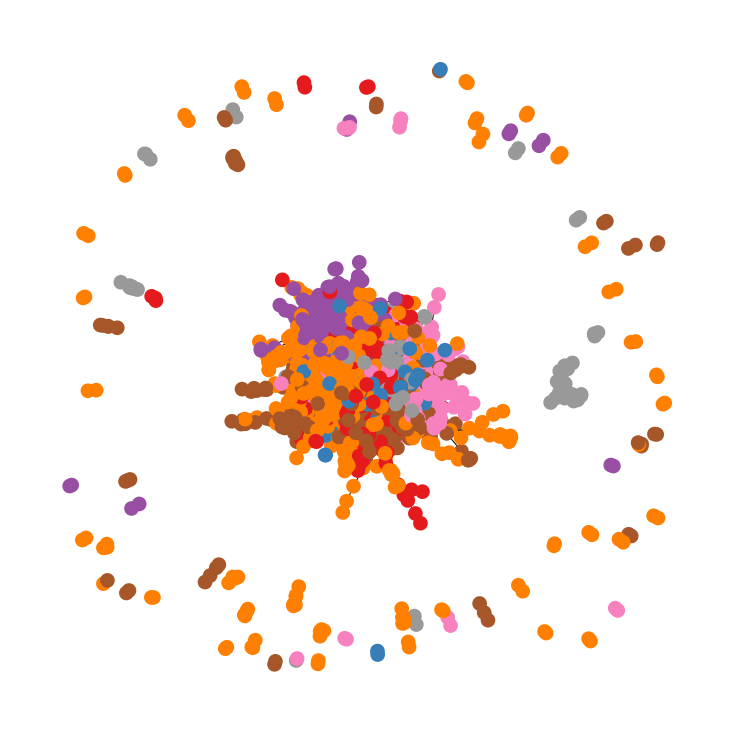

In [12]:
plt.figure(figsize=(10, 10))
cora = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(cora, to_undirected=True)
coragraph = to_networkx(cora)
node_labels = data.y[list(coragraph.nodes)].numpy()
nx.draw(g, cmap = plt.get_cmap('Set1'), node_color = node_labels, node_size=75, linewidths=6)

In [13]:
from torch_geometric.nn import GCNConv

In [14]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [15]:
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [17]:
# train the model
model.train()
losses = []
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

Epoch: 10, Loss: 0.8216, Training Acc: 0.9143
Epoch: 20, Loss: 0.2072, Training Acc: 0.9857
Epoch: 30, Loss: 0.0913, Training Acc: 0.9929
Epoch: 40, Loss: 0.0476, Training Acc: 1.0000
Epoch: 50, Loss: 0.0441, Training Acc: 0.9929
Epoch: 60, Loss: 0.0401, Training Acc: 1.0000
Epoch: 70, Loss: 0.0350, Training Acc: 1.0000
Epoch: 80, Loss: 0.0270, Training Acc: 1.0000
Epoch: 90, Loss: 0.0480, Training Acc: 0.9929
Epoch: 100, Loss: 0.0327, Training Acc: 1.0000
Epoch: 110, Loss: 0.0346, Training Acc: 1.0000
Epoch: 120, Loss: 0.0285, Training Acc: 1.0000
Epoch: 130, Loss: 0.0224, Training Acc: 1.0000
Epoch: 140, Loss: 0.0289, Training Acc: 1.0000
Epoch: 150, Loss: 0.0190, Training Acc: 1.0000
Epoch: 160, Loss: 0.0259, Training Acc: 1.0000
Epoch: 170, Loss: 0.0298, Training Acc: 1.0000
Epoch: 180, Loss: 0.0246, Training Acc: 1.0000
Epoch: 190, Loss: 0.0247, Training Acc: 1.0000
Epoch: 200, Loss: 0.0391, Training Acc: 0.9929


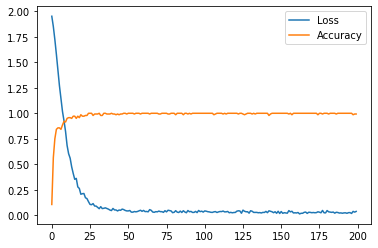

In [18]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [19]:
# evaluate the model on test set
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8100
